In [1]:
import sqlite3
import random
import numpy as np
import pandas as pd
from scipy.stats import bootstrap, permutation_test
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Step 1: Read CSV file
df = pd.read_csv('movieRatingsData.csv') # ingest the data in one line
df = df.apply(pd.to_numeric, errors='coerce') # makes sure all strings are converted to floats

# Step 2: Connect to SQLite
conn = sqlite3.connect('movie_ratings_data.db')

# Step 3: Write the data to SQLite table
df.to_sql('ratings_matrix', conn, index=False, if_exists='replace')

# Step 4: Commit changes and close the connection
conn.commit()
conn.close()

In [3]:
# Step 1: Establish a new connection
conn = sqlite3.connect('movie_ratings_data.db')

# Step 2: Query all columns from the 'ratings_matrix' table
query = 'SELECT * FROM ratings_matrix'
data = pd.read_sql_query(query, conn)

# Step 3: Close the connection
conn.close()

In [5]:
data.columns

Index(['10 things I hate about you (1999)', '12 Monkeys (1995)',
       '13 going on 30 (2004)', '21 Grams (2003)', '25th hour (2002)',
       '28 days later (2002)', '3000 Miles to Graceland (2001)',
       '8 Mile (2002)', 'A Night at the Roxbury (1998) ',
       'A time to kill (1996)',
       ...
       'Toy Story (1995)', 'Toy Story 2 (1999)', 'Unforgiven (1992)',
       'What Lies Beneath (2000)', 'What Women Want (2000)',
       'Wild Wild West (1999)', 'Wing Commander (1999)', 'X-Men (2000)',
       'X2 (2003)', 'Zoolander (2001)'],
      dtype='object', length=209)

In [54]:
film_1 = "Reservoir Dogs (1992)"
film_2 = "Good Will Hunting (1997)"

In [55]:
sub_data = data[[film_1, film_2]]
sub_data_row_drop = sub_data.dropna(axis=0)

In [56]:
sub_data_row_drop

,Reservoir Dogs (1992),Good Will Hunting (1997)
0,3.5,3.5
1,4.0,4.0
4,1.5,3.5
5,4.0,3.5
6,3.5,4.0
...,...,...
3160,3.0,3.5
3163,4.0,3.5
3169,4.0,2.5
3185,4.0,3.0


In [57]:
pulp = sub_data_row_drop[film_1]
magno = sub_data_row_drop[film_2]
test_stat = pulp.mean() - magno.mean()
test_stat

0.0475517890772128

In [58]:
# Start permutation test
num_reps = int(1e4) # same number as before
joint_data = np.concatenate((pulp, magno)) # joint representation of both ratings arrays
n1 = len(pulp) 
n2 = len(joint_data)
rng = np.random.default_rng(69420)
shuffled_stats = []
for i in range(num_reps): # loop thru each
    shuffled_indices = rng.permutation(n2) # randomly shuffle n2
    shuffled_group_1 = joint_data[shuffled_indices[:n1]]
    shuffled_group_2 = joint_data[shuffled_indices[n1:]]
    shuffled_stats.append(np.mean(shuffled_group_1) - np.mean(shuffled_group_2))

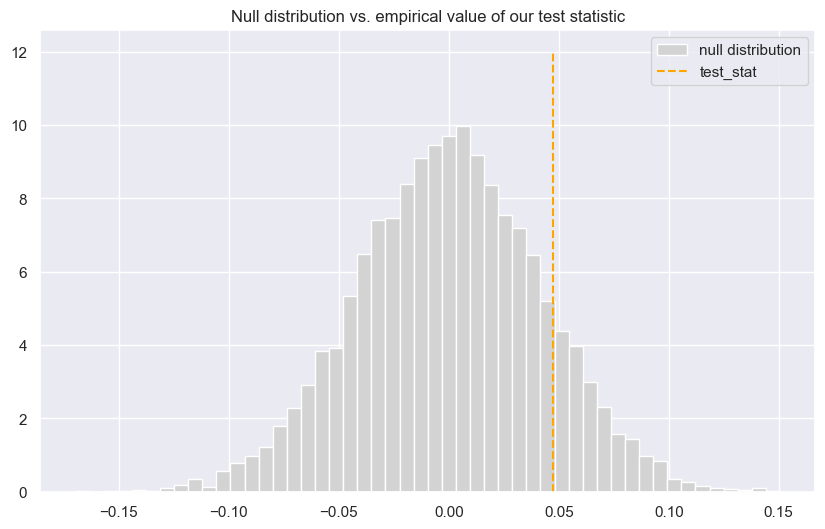

In [59]:
plt.figure(figsize=(10,6))
plt.hist(shuffled_stats, bins=50, density=True, color='lightgrey', label='null distribution')
plt.vlines(test_stat, 0, 12, color='orange', ls='--', label='test_stat')
plt.title('Null distribution vs. empirical value of our test statistic')
plt.legend()
plt.show()

In [60]:
p_val = len(np.argwhere(shuffled_stats>=test_stat))/num_reps
print('p-val:', p_val)

p-val: 0.1281


In [75]:
sub_data_zoo = data["Saving Private Ryan (1998)"]

In [76]:
sub_data_zoo_drop = sub_data_zoo.dropna()

In [77]:
# input data has to be a sequence
bootstrap_ci = bootstrap((list(sub_data_zoo_drop),), 
                         np.mean, 
                         n_resamples = int(1e4), 
                         random_state=0, 
                         confidence_level=0.95)
bootstrap_ci

BootstrapResult(confidence_interval=ConfidenceInterval(low=3.107749974296316, high=3.1865032327586205), bootstrap_distribution=array([3.12241379, 3.13283944, 3.12443427, ..., 3.13316272, 3.16136853,
       3.12020474]), standard_error=0.020231518240036068)

In [78]:
ratings_array = np.array(sub_data_zoo_drop) # set the movie of interest's ratings as ratings_array
num_experiments = int(1e4) # number of times to simulate the statistical experiment
n_samples = len(ratings_array) # play around at home with different values and note the differences
rng = np.random.default_rng(69420) # set the seed to any number
bootstrapped_means = [] # init empty list
for i in range(num_experiments): # loop through each exp
    random_idx = rng.integers(low=0, high=len(ratings_array), size=n_samples) # note: with replacement
    bootstrapped_means.append(ratings_array[random_idx].mean()) # compute the mean and store in correspoinding element of hte list

In [79]:
confidence_level = 0.95
sorted_data = np.sort(bootstrapped_means) # sort the values
lower_percentile = (1 - confidence_level)/2
upper_percentile = 1 - lower_percentile
lower_index = int(lower_percentile*num_experiments)
upper_index = num_experiments - lower_index
lower_bound = sorted_data[lower_index]
upper_bound = sorted_data[upper_index]

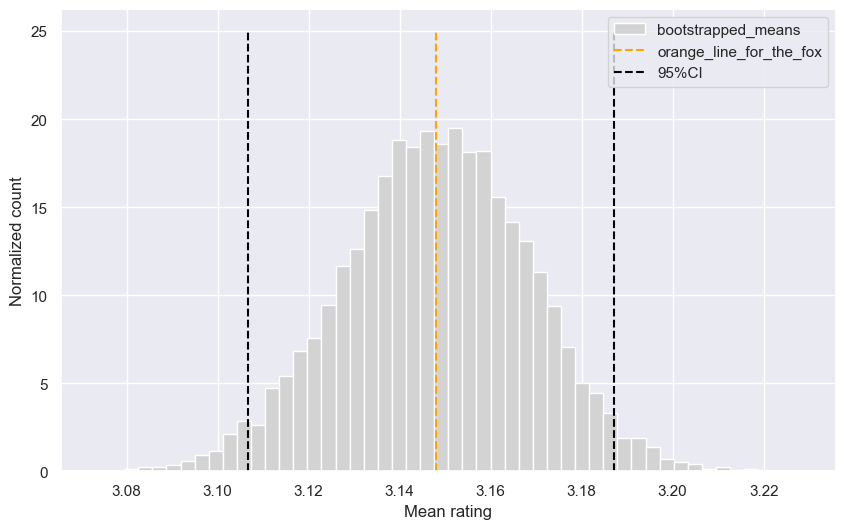

In [80]:
plt.figure(figsize=(10,6))
plt.hist(bootstrapped_means, bins=50, density=True, color='lightgrey', label='bootstrapped_means')
plt.vlines(np.mean(ratings_array), 0, 25, color='orange', ls='--', label='orange_line_for_the_fox') # emp. sample mean
plt.vlines(lower_bound, 0, 25, color='black', ls='--', label='95%CI')
plt.vlines(upper_bound, 0, 25, color='black', ls='--')
plt.xlabel('Mean rating')
plt.ylabel('Normalized count')
plt.legend()
plt.show()

In [81]:
p_val = len(np.argwhere(ratings_array>=3))/len(ratings_array)
print('p-val:', p_val)

p-val: 0.7473060344827587


In [66]:
whole = 0
valid = 0
for a in range(27):
    for b in range(27):
        for c in range(27):
            for d in range(27):
                for e in range(27):
                    whole += 1
                    if a + b + c + d + e == 26 and 200*a+400*b+600*c+800*d+1000*e >= 14400:
                        valid+=1
valid / whole

0.0012393278456679661